In [1]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
import graph
from graph import *
from node import *
from part import *
from sklearn.model_selection import train_test_split

# Suppose you have your own classes:
# Graph, Node, Part
# For illustration, here are minimal stubs:

############################################################
# 1) Prepare sample graphs
############################################################
with open('./data/graphs.dat', 'rb') as file:
    train_graphs_list: List[Graph] = pickle.load(file)
    train_graphs_list, test_graphs = train_test_split(train_graphs_list, test_size=0.2, random_state=42)



############################################################
# 2) Build a PyTorch Dataset
############################################################
class LinkPredictionDataset(Dataset):

    """
    Creates positive/negative samples from each Graph.
    For each Graph:
      - Collect all nodes
      - For every pair (i, j), check if it's an edge (label=1) or not (label=0)
    """
    def __init__(self, graphs: List[Graph]):
        super().__init__()
        self.samples = []

        for g in graphs:
            # Get the nodes and edges
            node_list = g.get_nodes()          # List[Node]
            edge_list = g.get_edges()          # List of (Node, Node)
            edge_set = self.get_edge_list(edge_list)        # for quick membership checks

            # Map node ID -> (part_id, family_id)
            node_id_to_features = {}
            for node in node_list:
                node_id_to_features[node.get_id()] = (
                    node.get_part().get_part_id(),
                    node.get_part().get_family_id()
                )

            # We'll gather all node IDs from the node list
            node_ids = [n.get_id() for n in node_list]
            id_to_node = {n.get_id(): n for n in node_list}

            # Create all (i, j) pairs
            for i in node_ids:
                for j in node_ids:
                    if i == j:
                        continue
                    part_i, fam_i = node_id_to_features[i]
                    part_j, fam_j = node_id_to_features[j]

                    # Sort the pair for an undirected edge check
                    pair = tuple(sorted([id_to_node[i], id_to_node[j]],
                                        key=lambda x: x.get_id()))
                    label = 1 if pair in edge_set else 0

                    self.samples.append((int(part_i), int(fam_i), int(part_j), int(fam_j), int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]  # (part_i, fam_i, part_j, fam_j, label)
    def get_edge_list(self, __edges: Dict[Node, List[Node]]):
        edge_pairs = set()  # use a set to avoid duplicates

        for src, neighbors in __edges.items():
            for dst in neighbors:
                # Sort the pair so that (NodeA, NodeB) == (NodeB, NodeA)
                sorted_pair = tuple(sorted([src, dst], key=lambda n: n.get_id()))
                edge_pairs.add(sorted_pair)

        return edge_pairs  # Now we have a list of (Node, Node) pairs


############################################################
# 3) Create the dataset & figure out vocab size
############################################################
all_part_ids = []
all_family_ids = []
for graph in train_graphs_list:
    for n in graph.get_nodes():
        all_part_ids.append(int(n.get_part().get_part_id()))
        all_family_ids.append(int(n.get_part().get_family_id()))

part_vocab_size = max(all_part_ids) + 1
family_vocab_size = max(all_family_ids) + 1

dataset = LinkPredictionDataset(train_graphs_list)
print("Number of training pairs:", len(dataset))

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


############################################################
# 4) Define a simple model for link prediction
############################################################
class EdgePredictor(nn.Module):
    def __init__(self, part_vocab_size, family_vocab_size,
                 embed_dim=16, hidden_dim=32):
        super().__init__()
        self.part_embedding = nn.Embedding(part_vocab_size, embed_dim)
        self.family_embedding = nn.Embedding(family_vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim * 4, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, part_i, fam_i, part_j, fam_j):
        """
        part_i, fam_i, part_j, fam_j are integer tensors
        of shape (batch_size,).
        """
        pi = self.part_embedding(part_i)  # (B, embed_dim)
        fi = self.family_embedding(fam_i) # (B, embed_dim)
        pj = self.part_embedding(part_j)  # (B, embed_dim)
        fj = self.family_embedding(fam_j) # (B, embed_dim)

        x = torch.cat([pi, fi, pj, fj], dim=1)  # (B, 4*embed_dim)
        x = self.relu(self.fc1(x))             # (B, hidden_dim)
        x = self.fc2(x)                        # (B, 1)
        return x.squeeze(1)  # (B,)


############################################################
# 5) Train the model
############################################################
model = EdgePredictor(part_vocab_size, family_vocab_size, embed_dim=16, hidden_dim=32)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 5  # For demo, keep it smaller
model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    for batch in dataloader:
        part_i, fam_i, part_j, fam_j, label = batch
        # Convert to Long / Float for embeddings + BCE
        part_i = part_i.long()
        fam_i  = fam_i.long()
        part_j = part_j.long()
        fam_j  = fam_j.long()
        label  = label.float()

        optimizer.zero_grad()
        logits = model(part_i, fam_i, part_j, fam_j)
        loss = criterion(logits, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")


############################################################
# 6) Predict edges on NEW sets of (part_id, family_id)
############################################################


@torch.no_grad()
def predict_edges(model, parts, threshold=0.5):
    """
    part_family_list: list of (part_id, family_id)
    We will return a list of edges (i, j) for i < j if predicted prob > threshold.
    """
    model.eval()
    n = len(parts)
    graph = Graph()

    for i in range(n):
        for j in range(i + 1, n):
            part_i, fam_i = int(parts[i].get_part_id()), int(parts[i].get_family_id())
            part_j, fam_j = int(parts[j].get_part_id()), int(parts[j].get_family_id())

            pi = torch.tensor([part_i], dtype=torch.long)
            fi = torch.tensor([fam_i], dtype=torch.long)
            pj = torch.tensor([part_j], dtype=torch.long)
            fj = torch.tensor([fam_j], dtype=torch.long)

            logit = model(pi, fi, pj, fj)
            prob = torch.sigmoid(logit)
            if prob.item() > threshold:
                graph.add_edge(parts[i], parts[j])
                graph.add_edge(parts[j], parts[i])

    return graph


# Example of new data:
test_parts = train_graphs_list[0].get_parts()

predicted = predict_edges(model, list(test_parts), threshold=0.5)
train_graphs_list[0].draw()
predicted.draw()



Number of training pairs: 511736


KeyboardInterrupt: 

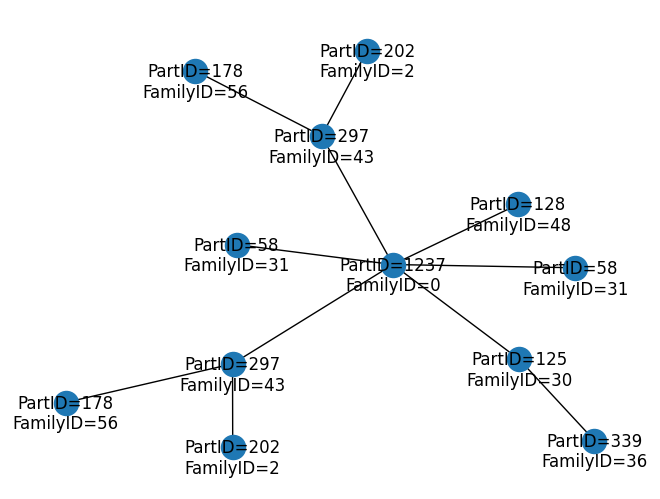

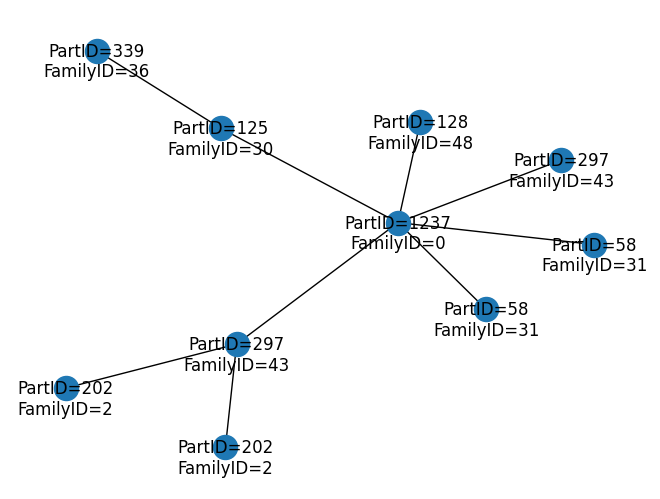

In [5]:
@torch.no_grad()
def predict_edges(model, parts, threshold=0.5):
    """
    part_family_list: list of (part_id, family_id)
    We will return a list of edges (i, j) for i < j if predicted prob > threshold.
    """
    model.eval()
    n = len(parts)
    graph = Graph()

    for i in range(n):
        for j in range(i+1, n):
            part_i, fam_i = int(parts[i].get_part_id()), int(parts[i].get_family_id())
            part_j, fam_j = int(parts[j].get_part_id()), int(parts[j].get_family_id())

            pi = torch.tensor([part_i], dtype=torch.long)
            fi = torch.tensor([fam_i],  dtype=torch.long)
            pj = torch.tensor([part_j], dtype=torch.long)
            fj = torch.tensor([fam_j],  dtype=torch.long)

            logit = model(pi, fi, pj, fj)
            prob = torch.sigmoid(logit)
            if prob.item() > threshold:
                graph.add_edge(parts[i], parts[j])
                graph.add_edge(parts[j], parts[i])

    return graph

# Example of new data:
test_parts = train_graphs_list[3].get_parts()

predicted = predict_edges(model, list(test_parts), threshold=0.5)
train_graphs_list[3].draw()
predicted.draw()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pickle
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

with open('./data/graphs.dat', 'rb') as file:
    train_graphs_list = pickle.load(file)
    train_graphs_list, test_graphs = train_test_split(train_graphs_list, test_size=0.2, random_state=42)

class GraphPredictor(nn.Module):
    def __init__(self, part_vocab_size, family_vocab_size, embed_dim=1, gnn_hidden_dim=32):
        super().__init__()
        self.part_embedding = nn.Embedding(part_vocab_size, embed_dim)
        self.family_embedding = nn.Embedding(family_vocab_size, embed_dim)
        self.gnn_hidden_dim = gnn_hidden_dim

        # MLP for initial node features
        self.node_mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, gnn_hidden_dim),
            nn.ReLU()
        )

        # Suppose we do 1 GNN layer or skip directly for brevity:
        self.gnn1 = nn.Linear(gnn_hidden_dim, gnn_hidden_dim)

        # Bilinear scoring matrix
        self.bilinear = nn.Parameter(torch.randn(gnn_hidden_dim, gnn_hidden_dim))
        # Or define it as nn.Linear(gnn_hidden_dim, gnn_hidden_dim, bias=False)

    def forward(self, part_ids, family_ids):
        # Node feature initialization
        part_emb = self.part_embedding(part_ids)          # (N, embed_dim)
        family_emb = self.family_embedding(family_ids)    # (N, embed_dim)
        node_features = torch.cat([part_emb, family_emb], dim=1)  # (N, 2*embed_dim)
        node_features = self.node_mlp(node_features)      # (N, gnn_hidden_dim)

        # Example GNN step (if you want)
        node_features = F.relu(self.gnn1(node_features))

        # Now do a bilinear form: (N,D) x (D,D) x (D,N) => (N,N)
        # 1) transform node_features: (N, D) -> (N, D) with W
        transformed = node_features @ self.bilinear       # (N, D)

        # 2) multiply by node_features^T => (N, N)
        # final scores = (N, D) @ (D, N) = (N, N)
        edge_logits = transformed @ node_features.transpose(0,1)

        return edge_logits  # raw logits, shape (N, N)

def train_graph_predictor(model, train_graphs_list, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        print("EPOCH:", epoch)
        total_loss = 0.0

        for graph in train_graphs_list:
            optimizer.zero_grad()

            # Sort nodes
            nodes = sorted(
                graph.get_nodes(),
                key=lambda node: (node.get_part().get_part_id(), node.get_part().get_family_id())
            )

            # Prepare part/family IDs
            part_ids = torch.tensor(
                [int(node.get_part().get_part_id()) for node in nodes],
                dtype=torch.long, device=device
            )
            family_ids = torch.tensor(
                [int(node.get_part().get_family_id()) for node in nodes],
                dtype=torch.long, device=device
            )

            # Build adjacency on the same device
            part_order = tuple(node.get_part() for node in nodes)
            adjacency_matrix = torch.tensor(
                graph.get_adjacency_matrix(part_order),
                dtype=torch.float32, device=device
            )

            # Forward pass
            logits = model(part_ids, family_ids)

            # Flatten for loss
            target = adjacency_matrix.flatten()
            loss = criterion(logits.flatten(), target)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_graphs_list)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

# Instantiate and move model to device
model = GraphPredictor(part_vocab_size, family_vocab_size, embed_dim=1, gnn_hidden_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

train_graph_predictor(model, train_graphs_list, optimizer, criterion, epochs=100)

@torch.no_grad()
def predict_graph(model, graph, threshold=0.5):
    model.eval()
    # Prepare inputs on the same device as the model
    nodes = graph.get_nodes()
    part_ids = torch.tensor(
        [int(node.get_part().get_part_id()) for node in nodes],
        dtype=torch.long, device=device
    )
    family_ids = torch.tensor(
        [int(node.get_part().get_family_id()) for node in nodes],
        dtype=torch.long, device=device
    )

    # Forward pass
    logits = model(part_ids, family_ids)
    probabilities = torch.sigmoid(logits)

    # Binarize using threshold
    predicted_adjacency = (probabilities > threshold).float()
    return predicted_adjacency

# Example prediction
predicted_adjacency = predict_graph(model, train_graphs_list[0])
print(predicted_adjacency)


Using device: cuda
EPOCH: 0
Epoch 1/100 - Loss: 0.2726
EPOCH: 1
Epoch 2/100 - Loss: 0.1569
EPOCH: 2
Epoch 3/100 - Loss: 0.1335
EPOCH: 3
Epoch 4/100 - Loss: 0.1203
EPOCH: 4
Epoch 5/100 - Loss: 0.1113
EPOCH: 5
Epoch 6/100 - Loss: 0.1044
EPOCH: 6
Epoch 7/100 - Loss: 0.0992
EPOCH: 7
Epoch 8/100 - Loss: 0.0952
EPOCH: 8
Epoch 9/100 - Loss: 0.0918
EPOCH: 9
Epoch 10/100 - Loss: 0.0895
EPOCH: 10
Epoch 11/100 - Loss: 0.0878
EPOCH: 11
Epoch 12/100 - Loss: 0.0865
EPOCH: 12
Epoch 13/100 - Loss: 0.0853
EPOCH: 13
Epoch 14/100 - Loss: 0.0843
EPOCH: 14
Epoch 15/100 - Loss: 0.0830
EPOCH: 15
Epoch 16/100 - Loss: 0.0820
EPOCH: 16
Epoch 17/100 - Loss: 0.0813
EPOCH: 17
Epoch 18/100 - Loss: 0.0807
EPOCH: 18
Epoch 19/100 - Loss: 0.0801
EPOCH: 19
Epoch 20/100 - Loss: 0.0795
EPOCH: 20
Epoch 21/100 - Loss: 0.0789
EPOCH: 21
Epoch 22/100 - Loss: 0.0786
EPOCH: 22
Epoch 23/100 - Loss: 0.0781
EPOCH: 23
Epoch 24/100 - Loss: 0.0778
EPOCH: 24
Epoch 25/100 - Loss: 0.0775
EPOCH: 25
Epoch 26/100 - Loss: 0.0771
EPOCH: 26
Ep

In [5]:
# Save the entire model to a file
torch.save(model.state_dict(), "graph_predictor_model.pth")


Lets see if the model predicts symmetric adj. matrix

In [6]:
# Check if the predicted adjacency matrix is symmetric
is_symmetric = torch.allclose(predicted_adjacency, predicted_adjacency.T, atol=1e-6)
print(f"Is the predicted adjacency matrix symmetric? {is_symmetric}")


Is the predicted adjacency matrix symmetric? True


The target is also symmetric :) 

In [7]:
part_order = tuple(node.get_part() for node in train_graphs_list[0].get_nodes())
            
            # Call get_adjacency_matrix with part_order
adjacency_matrix = torch.tensor(train_graphs_list[0].get_adjacency_matrix(part_order), dtype=torch.float32)
is_symmetric = torch.allclose(adjacency_matrix, adjacency_matrix.T, atol=1e-6)
print(f"Is the predicted adjacency matrix symmetric? {is_symmetric}")

Is the predicted adjacency matrix symmetric? True


Lets see where the prediction on a sample (first) differs from target

In [9]:
print(train_graphs_list[0].get_adjacency_matrix(part_order))
print(predicted_adjacency)
actual_adjacency = torch.tensor(train_graphs_list[0].get_adjacency_matrix(part_order), dtype=torch.float32, device=device)
difference = actual_adjacency - predicted_adjacency  # Differences (-1, 0, or 1)

# Find indices where they differ
differing_indices = torch.nonzero(difference, as_tuple=True)
differing_values_actual = actual_adjacency[differing_indices]
differing_values_predicted = predicted_adjacency[differing_indices]

# Print results
print("Differing Indices:", list(zip(differing_indices[0].tolist(), differing_indices[1].tolist())))
print("Actual Values at Differing Indices:", differing_values_actual.tolist())
print("Predicted Values at Differing Indices:", differing_values_predicted.tolist())

[[0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [1 1 0 1 1 1]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 1 0 0 0]]
tensor([[0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.]], device='cuda:0')
Differing Indices: []
Actual Values at Differing Indices: []
Predicted Values at Differing Indices: []


Evaluation of model on test data (20% of all graphs)

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

@torch.no_grad()
def evaluate_model(model, graph, threshold=0.5):
    """
    Evaluate the model on a single graph.
    
    Args:
        model: Trained model.
        graph: Graph object to evaluate.
        threshold: Threshold for classifying edges (default: 0.5).
    
    Returns:
        dict: Dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Get sorted part IDs and family IDs
    nodes = sorted(
        graph.get_nodes(),
        key=lambda node: (node.get_part().get_part_id(), node.get_part().get_family_id())
    )

    # Move tensors to the same device as the model
    part_ids = torch.tensor([int(node.get_part().get_part_id()) for node in nodes], dtype=torch.long).to(device)
    family_ids = torch.tensor([int(node.get_part().get_family_id()) for node in nodes], dtype=torch.long).to(device)

    # Get sorted part order and true adjacency matrix
    part_order = tuple(node.get_part() for node in nodes)
    true_adjacency = torch.tensor(graph.get_adjacency_matrix(part_order), dtype=torch.float32).to(device)

    # Predict adjacency matrix
    logits = model(part_ids, family_ids)
    probabilities = torch.sigmoid(logits)
    predicted_adjacency = (probabilities > threshold).float()

    # Move tensors to CPU before converting to numpy
    true_labels = true_adjacency.flatten().cpu().numpy()
    predicted_labels = predicted_adjacency.flatten().cpu().numpy()

    # Calculate metrics
    metrics = {
        "accuracy": accuracy_score(true_labels, predicted_labels),
        "precision": precision_score(true_labels, predicted_labels, zero_division=0),
        "recall": recall_score(true_labels, predicted_labels, zero_division=0),
        "f1_score": f1_score(true_labels, predicted_labels, zero_division=0),
    }
    return metrics

@torch.no_grad()
def createGraph(model, parts, threshold=0.01) -> Graph:
    """
    Evaluate the model on a single graph.

    Args:
        model: Trained model.
        graph: Graph object to evaluate.
        threshold: Threshold for classifying edges (default: 0.5).

    Returns:
        dict: Dictionary containing accuracy, precision, recall, and F1-score.
    """
    # Get sorted part IDs and family IDs
    parts = sorted(
        list(parts),
        key=lambda part: (part.get_part_id(), part.get_family_id())
    )

    # Move tensors to the same device as the model
    part_ids = torch.tensor([int(part.get_part_id()) for part in parts], dtype=torch.long).to(device)
    family_ids = torch.tensor([int(part.get_family_id()) for part in parts], dtype=torch.long).to(device)

    # Get sorted part order and true adjacency matrix
    part_order = tuple(part for part in parts)

    # Predict adjacency matrix
    logits = model(part_ids, family_ids)
    probabilities = torch.sigmoid(logits)
    predicted_adjacency = (probabilities > threshold).float()

    res = Graph()

    print(probabilities)

    num_parts = len(parts)
    for i in range(num_parts):
        for j in range(i + 1, num_parts):
            if predicted_adjacency[i][j]:  # If an edge exists
                res.add_undirected_edge(parts[i], parts[j])

    return res


# Evaluate on all training graphs
@torch.no_grad()
def evaluate_on_dataset(model, graphs, threshold=0.5):
    all_metrics = []

    for graph in graphs:
        metrics = evaluate_model(model, graph, threshold=threshold)
        all_metrics.append(metrics)

    # Aggregate metrics
    avg_metrics = {
        "accuracy": sum(m["accuracy"] for m in all_metrics) / len(all_metrics),
        "precision": sum(m["precision"] for m in all_metrics) / len(all_metrics),
        "recall": sum(m["recall"] for m in all_metrics) / len(all_metrics),
        "f1_score": sum(m["f1_score"] for m in all_metrics) / len(all_metrics),
    }
    return avg_metrics

# Perform evaluation
#avg_metrics = evaluate_on_dataset(model, test_graphs, threshold=0.5)
print("Evaluation Metrics:")
print(avg_metrics)


Evaluation Metrics:
{'accuracy': 0.9582727584360025, 'precision': 0.9033947078288378, 'recall': 0.9279288036093771, 'f1_score': 0.9073324734338183}


In [72]:
model_backup = model

In [75]:
from abc import ABC, abstractmethod
from itertools import permutations
import numpy as np
import pickle
from typing import Dict, List, Set, Tuple

from graph import Graph
from node import Node
from part import Part


class MyPredictionModel(ABC):
    """
    This class is a blueprint for your prediction model(s) serving as base class.
    """

    @abstractmethod
    def predict_graph(self, parts: Set[Part]) -> Graph:
        """
        Returns a graph containing all given parts. This method is called within the method `evaluate()`.
        :param parts: set of parts to form up an assembly (i.e. a graph)
        :return: graph
        """
        # TODO: implement this method
        ...

class OmarPredictionModel(MyPredictionModel):
    def __init__(self, model):
        self.model = model

    def predict_graph(self, parts: Set[Part]) -> Graph:
        return createGraph(self.model, parts)


def load_model(file_path: str) -> MyPredictionModel:
    """
        This method loads the prediction model from a file (needed for evaluating your model on the test set).
        :param file_path: path to file
        :return: the loaded prediction model
    """
    loaded_model = GraphPredictor(part_vocab_size, family_vocab_size, embed_dim=1, gnn_hidden_dim=32).to(device)

    loaded_model.load_state_dict(torch.load(file_path))

    # Set the model to evaluation mode before using it for inference
    loaded_model.eval()
    return OmarPredictionModel(loaded_model)



def evaluate(model: MyPredictionModel, data_set: List[Tuple[Set[Part], Graph]]) -> float:
    """
    Evaluates a given prediction model on a given data set.
    :param model: prediction model
    :param data_set: data set
    :return: evaluation score (for now, edge accuracy in percent)
    """
    sum_correct_edges = 0
    edges_counter = 0

    for input_parts, target_graph in data_set:
        predicted_graph = model.predict_graph(input_parts)

        # We prepared a simple evaluation metric `edge_accuracy()`for you
        # Think of other suitable metrics for this task and evaluate your model on them!
        # FYI: maybe some more evaluation metrics will be used in final evaluation
        edges_counter += len(input_parts) * len(input_parts)
        sum_correct_edges += edge_accuracy(predicted_graph, target_graph)

    # return value in percent
    return sum_correct_edges / edges_counter * 100


def edge_accuracy(predicted_graph: Graph, target_graph: Graph) -> int:
    """
    A simple evaluation metric: Returns the number of correct predicted edges.
    :param predicted_graph:
    :param target_graph:
    :return:
    """
    print(len(predicted_graph.get_nodes()))
    print(len(target_graph.get_nodes()))
    assert len(predicted_graph.get_nodes()) == len(target_graph.get_nodes()), 'Mismatch in number of nodes.'
    print(sorted(predicted_graph.get_parts()) )
    print(sorted(target_graph.get_parts() ))
    assert predicted_graph.get_parts() == target_graph.get_parts(), 'Mismatch in expected and given parts.'

    best_score = 0

    # Determine all permutations for the predicted graph and choose the best one in evaluation
    perms: List[Tuple[Part]] = __generate_part_list_permutations(predicted_graph.get_parts())

    # Determine one part order for the target graph
    target_parts_order = perms[0]
    target_adj_matrix = target_graph.get_adjacency_matrix(target_parts_order)

    for perm in perms:
        predicted_adj_matrix = predicted_graph.get_adjacency_matrix(perm)
        score = np.sum(predicted_adj_matrix == target_adj_matrix)
        best_score = max(best_score, score)

    return best_score


def __generate_part_list_permutations(parts: Set[Part]) -> List[Tuple[Part]]:
    """
    Different instances of the same part type may be interchanged in the graph. This method computes all permutations
    of parts while taking this into account. This reduced the number of permutations.
    :param parts: Set of parts to compute permutations
    :return: List of part permutations
    """
    # split parts into sets of same part type
    equal_parts_sets: Dict[Part, Set[Part]] = {}
    for part in parts:
        for seen_part in equal_parts_sets.keys():
            if part.equivalent(seen_part):
                equal_parts_sets[seen_part].add(part)
                break
        else:
            equal_parts_sets[part] = {part}

    multi_occurrence_parts: List[Set[Part]] = [pset for pset in equal_parts_sets.values() if len(pset) > 1]
    single_occurrence_parts: List[Part] = [next(iter(pset)) for pset in equal_parts_sets.values() if len(pset) == 1]

    full_perms: List[Tuple[Part]] = [()]
    for mo_parts in multi_occurrence_parts:
        perms = list(permutations(mo_parts))
        full_perms = list(perms) if full_perms == [()] else [t1 + t2 for t1 in full_perms for t2 in perms]

    # Add single occurrence parts
    full_perms = [fp + tuple(single_occurrence_parts) for fp in full_perms]
    assert all([len(perm) == len(parts) for perm in full_perms]), 'Mismatching number of elements in permutation(s).'
    return full_perms


with open('./data/graphs.dat', 'rb') as file:
    train_graphs: List[Graph] = pickle.load(file)

# Load the final model

model_file_path = 'graph_predictor_model.pth'
prediction_model: MyPredictionModel = load_model(model_file_path)

# For illustration, we compute the eval score on a portion of the training data
instances = [(graph.get_parts(), graph) for graph in train_graphs[:100]]
eval_score = evaluate(prediction_model, instances)



/tmp/ipykernel_220384/1461276092.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(file_path))


tensor([[6.9770e-05, 9.9997e-01, 9.9997e-01, 9.9997e-01, 9.9997e-01],
        [9.9996e-01, 1.1046e-13, 1.1046e-13, 1.1046e-13, 1.1046e-13],
        [9.9996e-01, 1.1046e-13, 1.1046e-13, 1.1046e-13, 1.1046e-13],
        [9.9996e-01, 1.1046e-13, 1.1046e-13, 1.1046e-13, 1.1046e-13],
        [9.9996e-01, 1.1046e-13, 1.1046e-13, 1.1046e-13, 1.1046e-13]],
       device='cuda:0')
5
5
[Part(PartID=1621, FamilyID=0), Part(PartID=58, FamilyID=31), Part(PartID=58, FamilyID=31), Part(PartID=58, FamilyID=31), Part(PartID=58, FamilyID=31)]
[Part(PartID=1621, FamilyID=0), Part(PartID=58, FamilyID=31), Part(PartID=58, FamilyID=31), Part(PartID=58, FamilyID=31), Part(PartID=58, FamilyID=31)]
tensor([[2.7294e-22, 1.0000e+00, 9.8622e-01, 9.8622e-01, 9.9039e-01, 9.9947e-01,
         9.9947e-01, 1.0000e+00],
        [1.0000e+00, 9.2150e-11, 2.5417e-04, 2.5417e-04, 6.8146e-07, 2.4778e-10,
         2.4778e-10, 1.5192e-10],
        [9.8875e-01, 2.1612e-04, 7.4406e-06, 7.4406e-06, 1.4147e-02, 6.7385e-05,
      

In [76]:
print(eval_score)

91.8491074435837
